In [169]:
# Plot the final policy on a nice map:
import numpy as np
import pickle
from build_database import flux_obj
from scipy import interpolate
from matplotlib import pyplot as plt
from GLD_file_tools import GLD_file_tools
from satellite import Satellite
import datetime
import ephem
from coordinate_structure import coordinate_structure
from coordinate_structure import transform_coords
from longitude_scaling import longitude_scaling
from ionoAbsorp import ionoAbsorp
import os
from mpl_toolkits.basemap import Basemap
from precip_model import precip_model
import itertools
from measurement_model import measurement_model
import random
import matplotlib.tri as mtri
import matplotlib as mpl
from fluxMDP import get_map_scaling

%matplotlib inline


# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size,
          'figure.autolayout': True,
          'figure.subplot.left': 0.15}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [123]:
run = '/Users/austin/FUSE2/shared/users/asousa/WIPP/fluxMDP/outputs/random_runs/run_IBK9PL/'

with open(os.path.join(run,'odb.pkl'),'rb') as file:
    odb = pickle.load(file)



Qs_to_load =['Q_i3539.pkl','Q_i20819.pkl','Q_i49619.pkl','Q_i96569.pkl']
Qlist = []
Plist = []
for Qcur in Qs_to_load:
    with open(os.path.join(run,Qcur),'rb') as file:
        Q = pickle.load(file)


    gLats = np.linspace(-90,90,np.shape(Q)[0])
    gLons = np.linspace(-180,180,np.shape(Q)[1])
    gTimes= np.linspace(0,24,np.shape(Q)[2])
    gActs = odb['actions']
    print gActs
    smoothing_radius = odb['smoothing_radius']

    #print np.shape(Q)

    policy = np.zeros([len(gLats),len(gLons),len(gTimes)])
    for lat_ind, lat in enumerate(gLats):
        for lon_ind, lon in enumerate(gLons):
            for t_ind, t in enumerate(gTimes):
                c = coordinate_structure(lat, lon, 0,'geomagnetic')
                W = get_map_scaling(gLats, gLons, c)
                policy[lat_ind,lon_ind,t_ind] = np.argmax([np.sum(Q[:,:,t,gActs.index(i)]*W) for i in gActs])
    Qlist.append(Q)
    Plist.append(policy)

['off', 'continuous', 'low', 'mid', 'high']
['off', 'continuous', 'low', 'mid', 'high']
['off', 'continuous', 'low', 'mid', 'high']
['off', 'continuous', 'low', 'mid', 'high']


/Users/austin/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


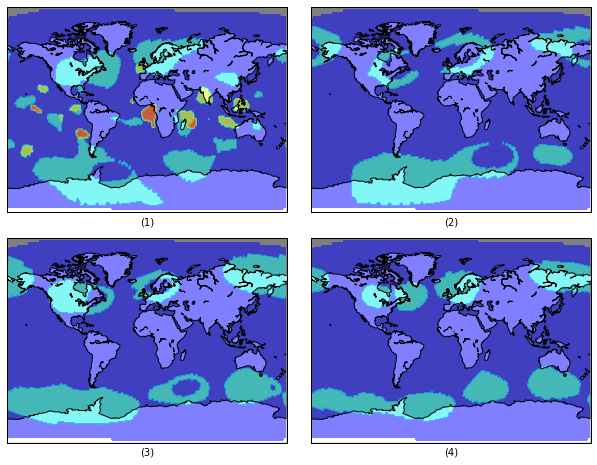

In [170]:
geo_lats = np.empty([len(gLons), len(gLats)])
geo_lons = np.empty([len(gLons), len(gLats)])
geo_lats_s = np.empty([len(gLons), len(gLats)])


for lo_ind, lo in enumerate(gLons):
    for la_ind, la in enumerate(gLats):
        temp_coords = coordinate_structure(la, lo, 400, 'geomagnetic')
        temp_coords.transform_to('geographic')
        geo_lats[lo_ind, la_ind] = temp_coords.lat()[0]
        geo_lons[lo_ind, la_ind] = temp_coords.lon()[0]



# Next, re-interpolate data onto a regular grid in geographic (basemap isn't happy with nonuniform)
rlons, rlats = np.meshgrid(np.linspace(-180,180,360), np.linspace(-90,90,180))
#clims = [1,5]

#f,ax = plt.subplots(len(Qs_to_load),1)
f,ax = plt.subplots(2,2)
ax = ax.flatten()


#cm,_ = mpl.colors.from_levels_and_colors(np.linspace(0,len(gActs),len(gActs))-0.5, ['b','c','r','w'], extend='neither')
#cm = mpl.colors.LinearSegmentedColormap.from_list("my_colormap", ('c','y','m','w'), N=5, gamma=1.0)
#cm='YlOrRd'
cm='jet'
for p in range(len(Qs_to_load)):
    policy = Plist[p]
    tli = mtri.LinearTriInterpolator(mtri.Triangulation(geo_lons.flatten(), geo_lats.flatten()),
                                     policy[:,:,0].T.flatten())
    rdata = tli(rlons,rlats)
    m = Basemap(projection='mill',lon_0=0,ax=ax[p])
    m.drawcoastlines(color='k',linewidth=1,ax=ax[p],zorder=2)
    #m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0])
    #m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,0])
    m.drawmapboundary(fill_color='grey')
    m.fillcontinents(color='white',lake_color='grey',zorder=0)
    ppl = m.contourf(rlons, rlats, rdata ,latlon=True,alpha=0.5,ax=ax[p],
                     levels=np.linspace(0,6,6),cmap=cm, vmin=0,vmax=5)
    ax[p].set_xlabel('(%g)'% (p + 1))
    

# cax,kw = mpl.colorbar.make_axes([a for a in ax])

# cb = plt.colorbar(mappable=ppl,cax=cax) # draw colorbar
# cb.set_ticklabels([a for a in gActs])
# cb.set_ticks(np.linspace(0.5,5.5,5))
plt.savefig('policies.png',dpi=300)

#print policy
#plt.pcolor(gLons, gLats, policy[:,:,0])